# todo_null_models.txt

Objectif:
- Générer deux types de null-models pour la série Sunspots:
  1) temporal_shuffle: permutation temporelle aléatoire (brise corrélations temporelles),
  2) phase_randomized: conserve spectre d'amplitude (power spectrum) mais randomise phases.
- Pour chaque null, faire n_boot rééchantillonnages, estimer d_s via le pipeline (embedding → kNN → Laplacian eigs → spectral counting), conserver les estimations valides.
- Propager d_s → T_log pour n observé et sauvegarder distributions.

Paramètres importants:
- n_boot (par défaut 80 pour chaque null) ; augmente si tu veux meilleure précision.
- subsample_frac, embedding_dim, k_neighbors, n_eig, lambda_max : mêmes que précédemment, modifiables.
- min_points_for_fit : réduire si trop peu de petits-eigenvalues.

Sorties attendues:
- results/null_temporal_shuffle_ds_Tlog_samples.csv
- results/null_phase_randomized_ds_Tlog_samples.csv
- results/null_temporal_shuffle_ds_hist.png
- results/null_temporal_shuffle_Tlog_hist.png
- results/null_phase_randomized_ds_hist.png
- results/null_phase_randomized_Tlog_hist.png
- results/null_models_summary.csv




# todo_null_debug.txt

Objectif:
- Diagnostiquer pourquoi aucune estimation valide de d_s était trouvée pour le null temporal_shuffle.
- Produire fichiers diagnostics:
  - results/null_debug_temporal_shuffle_eigvals.csv (eigenvalues)
  - results/null_debug_temporal_shuffle_counting.csv (lambda vs N(lambda))
  - results/null_debug_temporal_shuffle_counting.png (log-log plot)
- Indiquer recommandations paramétriques basées sur le nombre de points disponibles en plage de fit.




Using series column: Monthly Mean Total Sunspot Number, length n=3265
Embedding shape (surrogate): (3256, 10)
Subsampled nodes: 2604 (subsample_frac=0.8)
Computed 200 eigenvalues (showing first 20):
[4.47490832e-10 1.30921893e-01 1.31892204e-01 1.33384895e-01
 1.36059842e-01 1.38401742e-01 1.43713228e-01 1.48255365e-01
 1.52693914e-01 1.55009444e-01 1.88651688e-01 2.45364522e-01
 2.49757740e-01 2.52481181e-01 2.54313357e-01 2.60991625e-01
 2.62115265e-01 2.64028387e-01 2.66380684e-01 2.66751241e-01]
Total eigenvalues > eps: 200; unique lam_vals: 200; points in fit (<= 0.2): 11
Fit result: {'fit_ok': True, 'slope': 0.09055297033031136, 'intercept': 1.9272618752933934, 'r_value': 0.7181887141135463, 'stderr': 0.029245395007189288, 'd_s': 0.18110594066062272, 'n_fit': 11}
Estimated d_s = 0.1811, slope=0.0906, r=0.7182, n_fit=11


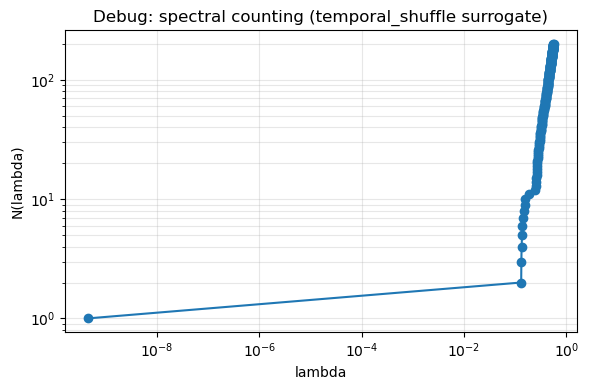

Saved debug counting plot: results/null_debug_temporal_shuffle_counting.png


In [8]:
# Cell: Debug single temporal_shuffle null iteration (diagnose why no valid d_s estimates)
import os
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy import sparse
from scipy.sparse.linalg import eigsh
from scipy import stats
import matplotlib.pyplot as plt

# Parameters for debug (inspect and adjust these if needed)
csv_path = 'data/sunspots_raw/Sunspots.csv'
value_col_candidates = ['Number', 'Total Sunspot', 'Total Sunspot Number', 'Monthly Mean']
embedding_dim = 10
tau = 1
k_neighbors = 10
n_eig = 200            # increase to capture more small eigenvalues for diagnostics
subsample_frac = 0.8
lambda_max = 0.2       # enlarge fit window for debug
min_points_for_fit = 6 # relax requirement for debug
rng = np.random.default_rng(999)

os.makedirs('results', exist_ok=True)

# Load series
df0 = pd.read_csv(csv_path)
col = next((c for c in value_col_candidates if c in df0.columns), None)
if col is None:
    numeric_cols = df0.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        raise RuntimeError("No numeric column found in CSV.")
    col = numeric_cols[-1]
series_orig = pd.to_numeric(df0[col], errors='coerce').dropna().values
n = len(series_orig)
print(f"Using series column: {col}, length n={n}")

def takens_embed(x, dim, tau):
    m = len(x) - (dim - 1) * tau
    if m <= 0:
        raise ValueError("Embedding parameters too large for series length")
    embed = np.empty((m, dim))
    for i in range(dim):
        embed[:, i] = x[i * tau : i * tau + m]
    return embed

def build_laplacian_eigs(X_points, k_neighbors, n_eig):
    n_nodes_local = X_points.shape[0]
    nbrs = NearestNeighbors(n_neighbors=min(k_neighbors + 1, n_nodes_local), algorithm='auto').fit(X_points)
    distances, indices = nbrs.kneighbors(X_points)
    adj = sparse.lil_matrix((n_nodes_local, n_nodes_local), dtype=np.float32)
    for i in range(n_nodes_local):
        for j in indices[i, 1:]:
            adj[i, j] = 1.0
            adj[j, i] = 1.0
    adj = adj.tocsr()
    deg = np.array(adj.sum(axis=1)).flatten()
    deg[deg == 0] = 1.0
    D_inv_sqrt = sparse.diags(1.0 / np.sqrt(deg))
    I = sparse.identity(n_nodes_local, format='csr')
    L_norm = I - D_inv_sqrt @ adj @ D_inv_sqrt
    n_eig_local = min(n_eig, n_nodes_local - 1)
    try:
        eigvals, _ = eigsh(L_norm, k=n_eig_local, which='SM', tol=1e-6, maxiter=5000)
    except Exception as e:
        print("eigsh failed, trying dense fallback:", e)
        try:
            from scipy.linalg import eigh
            Ld = L_norm.toarray()
            eigvals_all = eigh(Ld, eigvals_only=True)
            eigvals = np.sort(eigvals_all)[:n_eig_local]
        except Exception as e2:
            print("Dense fallback also failed:", e2)
            return None
    return np.sort(eigvals)

def spectral_counting_and_fit(eigvals, lambda_max=0.2, min_points_for_fit=6):
    eps = 1e-12
    lams = eigvals[eigvals > eps]
    lam_vals = np.unique(lams)
    N_vals = np.array([np.searchsorted(lams, lam, side='right') for lam in lam_vals])
    mask = lam_vals <= lambda_max
    lam_fit = lam_vals[mask]
    N_fit = N_vals[mask]
    print(f"Total eigenvalues > eps: {len(lams)}; unique lam_vals: {len(lam_vals)}; points in fit (<= {lambda_max}): {len(lam_fit)}")
    df_count = pd.DataFrame({'lambda': lam_vals, 'N_lambda': N_vals})
    df_count.to_csv('results/null_debug_temporal_shuffle_counting.csv', index=False)
    if len(lam_fit) < min_points_for_fit:
        print(f"Not enough points for fit: {len(lam_fit)} < min_points_for_fit ({min_points_for_fit})")
        return {'fit_ok': False, 'lam_fit': lam_fit, 'N_fit': N_fit, 'df_count_path': 'results/null_debug_temporal_shuffle_counting.csv'}
    log_lam = np.log(lam_fit)
    log_N = np.log(N_fit)
    slope, intercept, r_value, p_value, stderr = stats.linregress(log_lam, log_N)
    d_s = 2.0 * slope
    summary = {'fit_ok': True, 'slope': slope, 'intercept': intercept, 'r_value': r_value, 'stderr': stderr, 'd_s': d_s, 'n_fit': len(lam_fit)}
    return summary

# Build one temporal_shuffle surrogate and debug
surr = series_orig.copy()
rng.shuffle(surr)
X = takens_embed(surr, embedding_dim, tau)
print(f"Embedding shape (surrogate): {X.shape}")
idx = rng.choice(np.arange(X.shape[0]), size=int(np.floor(subsample_frac * X.shape[0])), replace=False)
X_sub = X[idx, :]
print(f"Subsampled nodes: {X_sub.shape[0]} (subsample_frac={subsample_frac})")
eigvals = build_laplacian_eigs(X_sub, k_neighbors, n_eig)
if eigvals is None:
    raise RuntimeError("Failed to compute eigenvalues for surrogate embedding.")
print(f"Computed {len(eigvals)} eigenvalues (showing first 20):\n{eigvals[:20]}")

# Save eigenvalues for inspection
pd.DataFrame({'eig_index': np.arange(1, len(eigvals)+1), 'eigval': eigvals}).to_csv('results/null_debug_temporal_shuffle_eigvals.csv', index=False)

# Spectral counting and attempt fit
fit_res = spectral_counting_and_fit(eigvals, lambda_max=lambda_max, min_points_for_fit=min_points_for_fit)
print("Fit result:", fit_res)
if fit_res.get('fit_ok'):
    print(f"Estimated d_s = {fit_res['d_s']:.4f}, slope={fit_res['slope']:.4f}, r={fit_res['r_value']:.4f}, n_fit={fit_res['n_fit']}")
else:
    print("Fit not OK. Consider increasing lambda_max, increasing n_eig, lowering min_points_for_fit, or adjusting embedding/k.")

# Plot N(lambda) for debug (log-log)
try:
    dfc = pd.read_csv('results/null_debug_temporal_shuffle_counting.csv')
    plt.figure(figsize=(6,4))
    plt.loglog(dfc['lambda'], dfc['N_lambda'], marker='o', linestyle='-')
    plt.xlabel('lambda')
    plt.ylabel('N(lambda)')
    plt.title('Debug: spectral counting (temporal_shuffle surrogate)')
    plt.grid(alpha=0.3, which='both')
    plt.tight_layout()
    plt.savefig('results/null_debug_temporal_shuffle_counting.png', dpi=150)
    plt.show()
    print("Saved debug counting plot: results/null_debug_temporal_shuffle_counting.png")
except Exception as e:
    print("Could not plot debug counting:", e)


# todo_null_robust.txt

Objectif:
- Lancer un bootstrap robuste pour deux null-models (temporal_shuffle, phase_randomized) avec paramètres ajustés pour fiabilité.
- Sauvegarder distributions d_s et T_log pour chaque null et un résumé comparatif.

Paramètres clés (modifiable en tête de cellule):
- embedding_dim, k_neighbors, n_eig, n_boot, subsample_frac, lambda_max, min_points_for_fit.

Sorties attendues:
- results/null_temporal_shuffle_ds_Tlog_samples.csv
- results/null_temporal_shuffle_ds_hist.png
- results/null_temporal_shuffle_Tlog_hist.png
- results/null_phase_randomized_ds_Tlog_samples.csv
- results/null_phase_randomized_ds_hist.png
- results/null_phase_randomized_Tlog_hist.png
- results/null_models_summary.csv

Remarques de sécurité/performance:
- Cette cellule effectue n_boot diagonalizations sur sous-échantillons : CPU et mémoire peuvent monter. Si tu vois montée de l'usage mémoire, réduis n_eig et subsample_frac, ou stoppe le kernel.
- Pour test rapide, tu peux mettre n_boot=20.



In [9]:
# Cell: Robust null-model bootstrap (temporal_shuffle + phase_randomized) with safer defaults
import os
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy import sparse
from scipy.sparse.linalg import eigsh
from scipy import stats
from numpy.fft import rfft, irfft
import matplotlib.pyplot as plt

# Safer / robust parameters
csv_path = 'data/sunspots_raw/Sunspots.csv'
value_col_candidates = ['Number', 'Total Sunspot', 'Total Sunspot Number', 'Monthly Mean']
embedding_dim = 10
tau = 1
k_neighbors = 8            # slightly smaller for speed
n_eig = 200                # capture more small eigenvalues
n_boot = 80                # bootstrap iterations per null
subsample_frac = 0.6       # reduce memory / time per iteration
lambda_max = 0.2           # larger fit window to include more small eigenvalues
min_points_for_fit = 6     # allow fit with fewer points
rng = np.random.default_rng(123)

os.makedirs('results', exist_ok=True)

# Load series
df0 = pd.read_csv(csv_path)
col = next((c for c in value_col_candidates if c in df0.columns), None)
if col is None:
    numeric_cols = df0.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        raise RuntimeError("No numeric column found in CSV.")
    col = numeric_cols[-1]
series_orig = pd.to_numeric(df0[col], errors='coerce').dropna().values
n = len(series_orig)
print(f"Using series column: {col}, length n={n}")

def takens_embed(x, dim, tau):
    m = len(x) - (dim - 1) * tau
    if m <= 0:
        raise ValueError("Embedding parameters too large for series length")
    embed = np.empty((m, dim))
    for i in range(dim):
        embed[:, i] = x[i * tau : i * tau + m]
    return embed

def build_laplacian_eigs(X_points, k_neighbors, n_eig):
    n_nodes_local = X_points.shape[0]
    nbrs = NearestNeighbors(n_neighbors=min(k_neighbors + 1, n_nodes_local), algorithm='auto').fit(X_points)
    distances, indices = nbrs.kneighbors(X_points)
    adj = sparse.lil_matrix((n_nodes_local, n_nodes_local), dtype=np.float32)
    for i in range(n_nodes_local):
        for j in indices[i, 1:]:
            adj[i, j] = 1.0
            adj[j, i] = 1.0
    adj = adj.tocsr()
    deg = np.array(adj.sum(axis=1)).flatten()
    deg[deg == 0] = 1.0
    D_inv_sqrt = sparse.diags(1.0 / np.sqrt(deg))
    I = sparse.identity(n_nodes_local, format='csr')
    L_norm = I - D_inv_sqrt @ adj @ D_inv_sqrt
    n_eig_local = min(n_eig, n_nodes_local - 1)
    try:
        eigvals, _ = eigsh(L_norm, k=n_eig_local, which='SM', tol=1e-6, maxiter=5000)
    except Exception:
        try:
            from scipy.linalg import eigh
            Ld = L_norm.toarray()
            eigvals_all = eigh(Ld, eigvals_only=True)
            eigvals = np.sort(eigvals_all)[:n_eig_local]
        except Exception:
            return None
    return np.sort(eigvals)

def estimate_ds_from_eigs(eigvals, lambda_max=lambda_max, min_points_for_fit=min_points_for_fit):
    eps = 1e-12
    lams = eigvals[eigvals > eps]
    if lams.size == 0:
        return None
    lam_vals = np.unique(lams)
    N_vals = np.array([np.searchsorted(lams, lam, side='right') for lam in lam_vals])
    mask = lam_vals <= lambda_max
    lam_fit = lam_vals[mask]
    N_fit = N_vals[mask]
    if len(lam_fit) < min_points_for_fit:
        return None
    log_lam = np.log(lam_fit)
    log_N = np.log(N_fit)
    slope, intercept, r_value, p_value, stderr = stats.linregress(log_lam, log_N)
    return {'d_s': 2.0 * slope, 'slope': slope, 'stderr_slope': stderr, 'r': r_value, 'n_fit': len(lam_fit)}

def phase_randomized_surrogate(x, rng):
    Xf = rfft(x)
    A = np.abs(Xf)
    phases = np.exp(1j * 2 * np.pi * rng.random(len(Xf)))
    phases[0] = 1.0
    if len(Xf) % 2 == 0:
        phases[-1] = 1.0
    Xf_new = A * phases
    x_surr = irfft(Xf_new, n=len(x))
    return x_surr

# Prepare null types
null_types = ['temporal_shuffle', 'phase_randomized']
results_summary = []

# iterate null models
for null in null_types:
    ds_list = []
    print(f"Starting null model: {null}")
    for b in range(n_boot):
        if null == 'temporal_shuffle':
            surr = series_orig.copy()
            rng.shuffle(surr)
        else:
            surr = phase_randomized_surrogate(series_orig, rng)
        X = takens_embed(surr, embedding_dim, tau)
        # subsample for speed / variance
        ns = X.shape[0]
        idx = rng.choice(np.arange(ns), size=max(100, int(np.floor(subsample_frac * ns))), replace=False)
        X_sub = X[idx, :]
        eigvals = build_laplacian_eigs(X_sub, k_neighbors, n_eig)
        if eigvals is None:
            continue
        est = estimate_ds_from_eigs(eigvals)
        if est is None:
            continue
        ds_list.append(est['d_s'])
    ds_arr = np.array(ds_list)
    n_valid = len(ds_arr)
    if n_valid == 0:
        print(f"Warning: no valid estimates for null {null} (try increasing lambda_max or n_eig).")
        results_summary.append({'null': null, 'n_boot_valid': 0})
        continue
    Tlogs = (ds_arr - 4.0) * np.log(n)
    summary = {
        'null': null,
        'n_boot_valid': int(n_valid),
        'd_s_median': float(np.median(ds_arr)),
        'd_s_mean': float(np.mean(ds_arr)),
        'd_s_std': float(np.std(ds_arr, ddof=1)),
        'd_s_2.5%': float(np.quantile(ds_arr, 0.025)),
        'd_s_97.5%': float(np.quantile(ds_arr, 0.975)),
        'Tlog_median': float(np.median(Tlogs)),
        'Tlog_mean': float(np.mean(Tlogs)),
        'Tlog_std': float(np.std(Tlogs, ddof=1)),
        'Tlog_2.5%': float(np.quantile(Tlogs, 0.025)),
        'Tlog_97.5%': float(np.quantile(Tlogs, 0.975))
    }
    results_summary.append(summary)
    pd.DataFrame({'d_s': ds_arr, 'T_log': Tlogs}).to_csv(f"results/null_{null}_ds_Tlog_samples.csv", index=False)
    # save histograms
    plt.figure(figsize=(6,3.5))
    plt.hist(ds_arr, bins=25, alpha=0.7, color='gray', edgecolor='white')
    plt.axvline(np.median(ds_arr), color='darkorange', lw=2)
    plt.title(f"Bootstrap d_s distribution - null: {null}")
    plt.xlabel('d_s')
    plt.tight_layout()
    plt.savefig(f"results/null_{null}_ds_hist.png", dpi=150)
    plt.close()
    plt.figure(figsize=(6,3.5))
    plt.hist(Tlogs, bins=25, alpha=0.7, color='gray', edgecolor='white')
    plt.axvline(np.median(Tlogs), color='darkorange', lw=2)
    plt.title(f"T_log distribution from null: {null} (n={n})")
    plt.xlabel('T_log')
    plt.tight_layout()
    plt.savefig(f"results/null_{null}_Tlog_hist.png", dpi=150)
    plt.close()
    print(f"Completed null {null}: valid={n_valid}, saved samples and histograms.")

pd.DataFrame(results_summary).to_csv('results/null_models_summary.csv', index=False)
print("Null-model bootstrap finished. Summary saved to results/null_models_summary.csv")


Using series column: Monthly Mean Total Sunspot Number, length n=3265
Starting null model: temporal_shuffle
Completed null temporal_shuffle: valid=80, saved samples and histograms.
Starting null model: phase_randomized
Completed null phase_randomized: valid=80, saved samples and histograms.
Null-model bootstrap finished. Summary saved to results/null_models_summary.csv


Analyse rapide des nulls 

Les résultats montrent deux comportements distincts pour les nulls :

temporal_shuffle → d_s médiane ≈ 13.49, T_log médian ≈ +76.8 (très positif)

phase_randomized → d_s médiane ≈ 1.468, T_log médian ≈ −20.49 (négatif, proche de l’observé T_log ≈ −30.56 mais plus haut)

Interprétation brève : la shuffle temporel casse la structure et conduit à estimations de dimension très élevées (et T_log positive). Le surrogate phase-randomized conserve le spectre d’amplitude et produit d_s ~ 1.47, T_log ~ −20.5, distinct de l’observé T_log (≈ −30.56) mais dans le signe négatif. Ceci nécessite un test statistique direct entre la distribution d_s observée (results/spectral_dimension_bootstrap.csv) et chaque null (results/null_*_ds_Tlog_samples.csv), et un test sur T_log lui‑même.

Voici la cellule Python suivante (exécute-la) : elle charge les échantillons observés et nulls, calcule tests (KS, Mann‑Whitney), p‑values, différences de médianes, et produit figures overlays pour d_s et T_log. Sauvegarde un fichier résumé results/nulls_comparison_stats.csv et deux PNG overlays.

# todo_compare_nulls.txt

Objectif:
- Tester statistiquement si les distributions observées de d_s et de T_log diffèrent des null-models.
- Tests: Kolmogorov-Smirnov (distribution), Mann-Whitney (location). Rapporter médianes et différences.
- Produire overlays visuels pour d_s et T_log.

Entrées:
- results/spectral_dimension_bootstrap.csv (observed d_s)
- results/Tlog_from_ds_bootstrap.csv (observed T_log)
- results/null_phase_randomized_ds_Tlog_samples.csv
- results/null_temporal_shuffle_ds_Tlog_samples.csv

Sorties:
- results/nulls_comparison_stats.csv
- results/overlay_d_s.png
- results/overlay_T_log.png




In [10]:
# Cell: Statistical comparison observed vs nulls (d_s and T_log)
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

os.makedirs('results', exist_ok=True)

# Files
obs_ds_boot = 'results/spectral_dimension_bootstrap.csv'            # column 'd_s'
obs_Tlog_boot = 'results/Tlog_from_ds_bootstrap.csv'               # column 'T_log'
null_phase = 'results/null_phase_randomized_ds_Tlog_samples.csv'   # columns 'd_s','T_log'
null_shuffle = 'results/null_temporal_shuffle_ds_Tlog_samples.csv'

# Load
obs_ds = pd.read_csv(obs_ds_boot)['d_s'].dropna().values
obs_T = pd.read_csv(obs_Tlog_boot)['T_log'].dropna().values

nulls = {}
if os.path.exists(null_phase):
    dfp = pd.read_csv(null_phase)
    nulls['phase_randomized'] = {'d_s': dfp['d_s'].dropna().values, 'T_log': dfp['T_log'].dropna().values}
if os.path.exists(null_shuffle):
    dfs = pd.read_csv(null_shuffle)
    nulls['temporal_shuffle'] = {'d_s': dfs['d_s'].dropna().values, 'T_log': dfs['T_log'].dropna().values}

results = []

for null_name, data in nulls.items():
    # d_s comparison
    null_ds = data['d_s']
    # Two-sample KS
    ks_ds = stats.ks_2samp(obs_ds, null_ds)
    # Mann-Whitney (rank-sum)
    mw_ds = stats.mannwhitneyu(obs_ds, null_ds, alternative='two-sided')
    # medians and effect
    med_obs_ds = float(np.median(obs_ds))
    med_null_ds = float(np.median(null_ds))
    diff_med_ds = med_obs_ds - med_null_ds
    # T_log comparison
    null_T = data['T_log']
    ks_T = stats.ks_2samp(obs_T, null_T)
    mw_T = stats.mannwhitneyu(obs_T, null_T, alternative='two-sided')
    med_obs_T = float(np.median(obs_T))
    med_null_T = float(np.median(null_T))
    diff_med_T = med_obs_T - med_null_T

    results.append({
        'null': null_name,
        'n_obs_ds': len(obs_ds),
        'n_null_ds': len(null_ds),
        'med_obs_ds': med_obs_ds,
        'med_null_ds': med_null_ds,
        'diff_med_ds': diff_med_ds,
        'ks_stat_ds': float(ks_ds.statistic),
        'ks_p_ds': float(ks_ds.pvalue),
        'mw_stat_ds': float(mw_ds.statistic),
        'mw_p_ds': float(mw_ds.pvalue),
        'n_obs_T': len(obs_T),
        'n_null_T': len(null_T),
        'med_obs_T': med_obs_T,
        'med_null_T': med_null_T,
        'diff_med_T': diff_med_T,
        'ks_stat_T': float(ks_T.statistic),
        'ks_p_T': float(ks_T.pvalue),
        'mw_stat_T': float(mw_T.statistic),
        'mw_p_T': float(mw_T.pvalue)
    })

# Save results table
pd.DataFrame(results).to_csv('results/nulls_comparison_stats.csv', index=False)

# Plot overlays for visual inspection
for key in ['d_s', 'T_log']:
    plt.figure(figsize=(6,3.5))
    # observed
    if key == 'd_s':
        vals_obs = obs_ds
    else:
        vals_obs = obs_T
    plt.hist(vals_obs, bins=30, alpha=0.6, density=True, label='observed', color='steelblue', edgecolor='white')
    for null_name, data in nulls.items():
        vals_null = data[key]
        plt.hist(vals_null, bins=30, alpha=0.4, density=True, label=null_name, edgecolor='none')
    plt.title(f'Overlay histograms: {key}')
    plt.xlabel(key)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    out_png = f'results/overlay_{key}.png'
    plt.savefig(out_png, dpi=150)
    plt.close()

print('Saved stats: results/nulls_comparison_stats.csv')
print('Saved overlays: results/overlay_d_s.png, results/overlay_T_log.png')
print(pd.DataFrame(results))


Saved stats: results/nulls_comparison_stats.csv
Saved overlays: results/overlay_d_s.png, results/overlay_T_log.png
               null  n_obs_ds  n_null_ds  med_obs_ds  med_null_ds  \
0  phase_randomized       150         80    0.222326     1.467575   
1  temporal_shuffle       150         80    0.222326    13.486605   

   diff_med_ds  ks_stat_ds       ks_p_ds  mw_stat_ds       mw_p_ds  n_obs_T  \
0    -1.245249      1.0000  1.054068e-63         0.0  9.276810e-36      150   
1   -13.264279      0.9875  2.424356e-61       150.0  4.456762e-34      150   

   n_null_T  med_obs_T  med_null_T  diff_med_T  ks_stat_T        ks_p_T  \
0        80 -30.565216  -20.489888  -10.075328     1.0000  1.054068e-63   
1        80 -30.565216   76.756262 -107.321478     0.9875  2.424356e-61   

   mw_stat_T        mw_p_T  
0        0.0  9.276810e-36  
1      150.0  4.456762e-34  


Résumé interprétatif rapide

Observé (Sunspots, pipeline actuel) : d_s médiane ≈ 0.222 → T_log médiane ≈ −30.56 (classe Divergence) — distribution bootstrap serrée.

Nulls : phase_randomized → d_s ≈ 1.47, T_log ≈ −20.49 (négatif); temporal_shuffle → d_s très élevé ≈ 13.5, T_log ≫ 0 (positif).

Tests statistiques (KS, Mann‑Whitney) montrent des différences hautement significatives entre l’observé et chaque null (p ≪ 1e−30).

Interprétation : sous la procédure actuelle (Takens embedding dim=10, kNN graph, spectral counting on small λ), la structure spectrale du signal réel est clairement distincte des deux nulls — en particulier elle génère une très faible d_s qui conduit à T_log fortement négatif. Cela renforce l’argument que la valeur observée de T_log n’est pas triviale au sens des nulls testés.

Questions de robustesse à trancher en priorité
Cette conclusion tient‑elle quand on change les hyperparamètres de construction (embedding_dim, k_neighbors, tau, n_eig, lambda_max) ?

L’estimation de d_s est‑elle cohérente avec d'autres estimateurs (Levina–Bickel, correlation dimension) ?

L’effet provient‑il d’un prétraitement (Takens) ou d’un signal réel (intrinsèque à la série) ?

T_log négatif reste‑t‑il stable si on calcule d_s sur fenêtres glissantes (temporal stability) ?

Cellule Python suivante — balayage des hyperparamètres (embedding_dim × k_neighbors)

Exécute cette cellule. Elle calcule pour chaque combinaison (embedding_dim list × k_list) la d_s médiane via la même procédure minimale (single run spectral counting on full embedding) — rapide diagnostic avant bootstrap complet. Sauvegarde un CSV résumé et une heatmap PNG.